In [1]:
import numpy as np
#from netCDF4 import Dataset as ncdset
import glob
import warnings
import datetime
import scipy.stats
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import os
import cdsapi
#from scipy.optimize import curve_fit
import xarray as xr
import xskillscore as xs
import pandas as pd
import xesmf as xesmf
import operator

In [2]:
def global_average(dataArray,latstr,lonstr):
    #Compute the latitude weighted average over the PNW
    #datout = dataArray.where((dataArray[latstr] > 40.5) & (dataArray[latstr] < 50.5) &
    #                        (dataArray[lonstr] > 235.5) & (dataArray[lonstr] < 253.5),drop=True)
    weights = np.cos(np.deg2rad(dataArray[latstr]))
    weights.name = 'weights'
    datout_weighted = dataArray.weighted(weights).mean(dim=[latstr,lonstr],skipna=True)
    return datout_weighted

def pnw_average(dataArray,latstr,lonstr):
    #Compute the latitude weighted average over the PNW
    datout = dataArray.where((dataArray[latstr] > 40.5) & (dataArray[latstr] < 50.5) &
                            (dataArray[lonstr] > 235.5) & (dataArray[lonstr] < 253.5),drop=True)
    weights = np.cos(np.deg2rad(datout[latstr]))
    weights.name = 'weights'
    datout_weighted = datout.weighted(weights).mean(dim=[latstr,lonstr],skipna=True)
    return datout_weighted

In [3]:
def coordnames(nci):
    if 'latitude' in list(nci.variables):
        latstr = 'latitude'
    elif 'lat' in list(nci.variables):
        latstr = 'lat'
    elif 'nav_lat' in list(nci.variables):
        latstr = 'nav_lat'

    if 'longitude' in list(nci.variables):
        lonstr = 'longitude'
    elif 'lon' in list(nci.variables):
        lonstr = 'lon'
    elif 'nav_lon' in list(nci.variables):
        lonstr = 'nav_lon'

    if 'lat' in list(nci.dims):
        latdim = 'lat'
        londim = 'lon'
    elif 'latitude' in list(nci.dims):
        latdim = 'latitude'
        londim = 'longitude'
    elif 'nav_lat' in list(nci.dims):
        latdim = 'nav_lat'
        londim = 'nav_lon'
    elif 'x' in list(nci.dims):
        latdim = 'y'
        londim = 'x'
    else:
        latdim = 'j'
        londim = 'i'
    return latstr,lonstr,latdim,londim

In [4]:
def fixlons(nci,latdim,londim,lonstr):
    lonarray = np.zeros(nci[lonstr].shape)
    ndim = lonarray.ndim
    if ndim == 2:
        if float(nci[lonstr].min()) < -1.:
            for i in range(nci[lonstr].shape[0]):
                for j in range(nci[lonstr].shape[1]):
                    if float(nci[lonstr][i,j]) < 0.:
                        lonarray[i,j] = nci[lonstr][i,j].data + 360.
                    else:
                        lonarray[i,j] = nci[lonstr][i,j].data
            nci[lonstr] = ([latdim, londim], lonarray)
    elif ndim == 1:
        if float(nci[lonstr].min()) < -1.:
            for i in range(nci[lonstr].shape[0]):
                if float(nci[lonstr][i]) < 0.:
                    lonarray[i] = nci[lonstr][i].data + 360.
                else:
                    lonarray[i] = nci[lonstr][i].data
            nci[lonstr] = ([londim], lonarray)
    return nci

In [5]:
def regrid_with_nan(data,regridder,C=10.):
    data = data + C
    data_rg = regridder(data)
    data_rg[data_rg==0.0] = np.nan
    data_rg = data_rg - C
    return data_rg

In [6]:
def compute_trend(nci):
    if 'ens' in nci.variables:
        nens = len(nci['ens'])
    else:
        nens = 1
    month_length = nci.time.dt.days_in_month
    tmp = (nci['pr']*month_length)/10

    p = pnw_average(tmp,'lat','lon')
    p = p.groupby('time.year').sum(dim='time',skipna=False)
    t = pnw_average(nci['tas'],'lat','lon')
    t = t.groupby('time.year').mean(dim='time')
    ptmp = xs.linslope(p['year'],p,dim='year',skipna=False)*100
    ttmp = xs.linslope(t['year'],t,dim='year',skipna=False)*100
    ptrend = np.nanmean(ptmp)
    ttrend = np.nanmean(ttmp)
    
    return ptrend,ttrend,ptmp

In [7]:
def seasonal_avg_vars(nci,model,latstr,lonstr,obs):
    years = list(nci.groupby('time.year').groups)
    nyr = len(years)
    seaskeys = ['DJF','MAM','JJA','SON']
    drs = {}
    if obs == False:
        ens = list(nci['ens'])
        nens = len(ens)
    for seas in seaskeys:
        drs[seas] = {}
    for iy in range(nyr-1):
        drs['DJF'][iy] = slice(str(years[iy])+'-12-01',str(years[iy+1])+'-02-28')
        drs['MAM'][iy] = slice(str(years[iy+1])+'-03-01',str(years[iy+1])+'-05-30')
        drs['JJA'][iy] = slice(str(years[iy+1])+'-06-01',str(years[iy+1])+'-08-30')
        drs['SON'][iy] = slice(str(years[iy+1])+'-09-01',str(years[iy+1])+'-11-30')

    nci['pranom'] = nci['pr'].groupby('time.month') - nci['pr'].groupby('time.month').mean(dim='time')
    nci['tasanom'] = nci['tas'].groupby('time.month') - nci['tas'].groupby('time.month').mean(dim='time')
    outvars = {}
    eli = {}
    pr = {}
    pranom = {}
    tas = {}
    tasanom = {}
    n34 = {}
    if obs == False:
        for seas in seaskeys:
            eli[seas] = np.zeros((nens,nyr-1))
            n34[seas] = np.zeros((nens,nyr-1))
            pr[seas]  = np.zeros((nens,nyr-1,len(nci[latstr]),len(nci[lonstr])))
            pranom[seas]  = np.zeros((nens,nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tas[seas] = np.zeros((nens,nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tasanom[seas] = np.zeros((nens,nyr-1,len(nci[latstr]),len(nci[lonstr])))

            for iy in range(nyr-1):
                eli[seas][:,iy]     = nci['eli'].sel(time=drs[seas][iy]).mean(dim='time').values
                n34[seas][:,iy]     = nci['n34'].sel(time=drs[seas][iy]).mean(dim='time').values
                pranom[seas][:,iy,:,:]  = nci['pranom'].sel(time=drs[seas][iy]).mean(dim='time').values
                tasanom[seas][:,iy,:,:] = nci['tasanom'].sel(time=drs[seas][iy]).mean(dim='time').values
                pr[seas][:,iy,:,:]      = nci['pr'].sel(time=drs[seas][iy]).mean(dim='time').values
                tas[seas][:,iy,:,:]     = nci['tas'].sel(time=drs[seas][iy]).mean(dim='time').values

            outvars[seas] = xr.Dataset(
                data_vars = dict(
                    eli=(['ens','time'], eli[seas]),
                    n34=(['ens','time'], n34[seas]),
                    pr=(['ens','time','lat','lon'],pr[seas]),
                    pranom=(['ens','time','lat','lon'],pranom[seas]),
                    tas=(['ens','time','lat','lon'],tas[seas]),
                    tasanom=(['ens','time','lat','lon'],tasanom[seas]),
                ),
                coords = dict(
                    ens = (['ens'], nci['ens'].data),
                    time = pd.date_range(str(years[0]+1)+'-01-01', periods=nyr-1, freq='AS'),
                    lat = (['lat'],nci[latstr].data),
                    lon = (['lon'],nci[lonstr].data),
                ),
                attrs=dict(description= seas + ' average variables from: ' + model),
            )
    elif obs == True:
        for seas in seaskeys:
            eli[seas] = np.zeros(nyr-1)
            n34[seas] = np.zeros(nyr-1)
            pr[seas]  = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            pranom[seas]  = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tas[seas] = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tasanom[seas] = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))

            for iy in range(nyr-1):
                eli[seas][iy]           = nci['eli'].sel(time=drs[seas][iy]).mean(dim='time').values
                n34[seas][iy]           = nci['n34'].sel(time=drs[seas][iy]).mean(dim='time').values
                pranom[seas][iy,:,:]    = nci['pranom'].sel(time=drs[seas][iy]).mean(dim='time').values
                tasanom[seas][iy,:,:]   = nci['tasanom'].sel(time=drs[seas][iy]).mean(dim='time').values
                pr[seas][iy,:,:]        = nci['pr'].sel(time=drs[seas][iy]).mean(dim='time').values
                tas[seas][iy,:,:]       = nci['tas'].sel(time=drs[seas][iy]).mean(dim='time').values

            outvars[seas] = xr.Dataset(
                data_vars = dict(
                    eli=(['time'], eli[seas]),
                    n34=(['time'], n34[seas]),
                    pr=(['time','lat','lon'],pr[seas]),
                    pranom=(['time','lat','lon'],pranom[seas]),
                    tas=(['time','lat','lon'],tas[seas]),
                    tasanom=(['time','lat','lon'],tasanom[seas]),
                ),
                coords = dict(
                    time = pd.date_range(str(years[0]+1)+'-01-01', periods=nyr-1, freq='AS'),
                    lat = (['lat'],nci[latstr].data),
                    lon = (['lon'],nci[lonstr].data),
                ),
                attrs=dict(description= seas + ' average variables from: ' + model),
            )
    return outvars

In [8]:
# Setting up CMIP6 datasets
diri='/glade/u/home/nlybarger/scratch/data/climate_data/cmip6/postproc/'
filis = sorted(glob.glob(diri + '*historical.nc'))
nfil = len(filis)
models = ['0']*nfil
for i in range(nfil):
    models[i] = filis[i].split('/')[-1].split('.')[0]

i=0
nci = {}
variants = {}
for fil in filis:
    nci[models[i]] = xr.open_dataset(fil,engine='netcdf4')
    variants[models[i]] = list(nci[models[i]]['ens'].data)
    nci[models[i]] = nci[models[i]].sel(time=slice('1901-01-01','1950-12-30'))
    i += 1
firstrun = True

In [9]:
odiri = '/glade/work/nlybarger/data/OBS/'
odsets = ['CRU','UDel']
fnames = ['cru','udel']
obs = {}
oyears = {}
for i in range(len(odsets)):
    obs[odsets[i]] = xr.open_dataset(odiri + odsets[i] + '/1deg.' + fnames[i] + '.global.p.t.nc',engine='netcdf4')
    obs[odsets[i]] = obs[odsets[i]].sel(time=slice('1901-01-01','1950-12-31'))
    oyears[odsets[i]] = list(obs[odsets[i]].groupby('time.year').groups)

n34f = '/glade/work/nlybarger/data/clim_indices/nino34.1870-2021.txt'
fp = open(n34f,'r')
n34o = np.genfromtxt(fp,delimiter=',',usecols=np.arange(1,13),dtype='f4')
n34o = np.reshape(n34o[30:150,:],(120*12))
fp.close()

elifi = '/glade/work/nlybarger/data/clim_indices/ELI_ERSSTv5_1854.01-2019.12.csv'
fp = open(elifi,'r')
elio = np.genfromtxt(fp,delimiter=',',usecols=np.arange(47,167),dtype='f4',skip_header=1)
elio = np.transpose(elio)
elio = np.reshape(elio,(120*12,))
fp.close()

indy = xr.Dataset(
        data_vars = dict(
            eli=(['time'], elio),
            n34=(['time'], n34o),
        ),
        coords = dict(
            time=(['time'], pd.date_range('1900-01-01','2019-12-31',freq='MS')),
        ),
)

oseasvars = {}
for dset in odsets:
    print(dset)
    obs[dset]['n34'] = (['time'],indy['n34'].sel(time=slice('1901-01-01','1950-12-31')).data)
    obs[dset]['eli'] = (['time'],indy['eli'].sel(time=slice('1901-01-01','1950-12-31')).data)
    oseasvars[dset] = seasonal_avg_vars(obs[dset],'obs','lat','lon',True)

pnw_dmeanto = {}
pnw_dsampto = {}
pnw_dmeanpo = {}
pnw_dsamppo = {}
pnw_ddjf_corrs = {}
pnw_dptrendo = {}
pnw_dttrendo = {}

glo_dmeanto = {}
glo_dsampto = {}
glo_dmeanpo = {}
glo_dsamppo = {}
glo_ddjf_corrs = {}
glo_dptrendo = {}
glo_dttrendo = {}

for dset in odsets:
    nyr = len(oyears[dset])
    ## Obs metrics
    # Mean-T
    #PNW
    tempyr = obs[dset]['tas'].groupby('time.year').mean(dim='time',skipna=True)
    gbto = pnw_average(obs[dset]['tas'],'lat','lon')
    pnw_dmeanto[dset] = pnw_average(tempyr,'lat','lon')
    pnw_dmeanto[dset] = pnw_dmeanto[dset].mean()
    #Global
    glo_dmeanto[dset] = global_average(tempyr,'lat','lon')
    glo_dmeanto[dset] = glo_dmeanto[dset].mean()
    
    
    # Seasonal Amplitude-T
    it=0
    pnw_dsampto[dset] = np.zeros(nyr)
    for year in oyears[dset]:
        tmp = gbto.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31'))
        pnw_dsampto[dset][it] = tmp.max()-tmp.min()
        it+=1
    pnw_dsampto[dset] = pnw_dsampto[dset].mean()

    # Mean-P
    #PNW
    tmp = obs[dset]['pr']/10
    gbpo = pnw_average(tmp,'lat','lon')
    pryr = tmp.groupby('time.year').sum(dim='time',skipna=False)
    pnw_dmeanpo[dset] = pnw_average(pryr,'lat','lon')
    pnw_dmeanpo[dset] = pnw_dmeanpo[dset].mean()
    #Global
    glo_dmeanpo[dset] = global_average(pryr,'lat','lon')
    glo_dmeanpo[dset] = glo_dmeanpo[dset].mean()
    
    # Seasonal Amplitude-P
    it=0
    pnw_dsamppo[dset] = np.zeros(nyr)
    for year in oyears[dset]:
        tmp = gbpo.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31'))
        pnw_dsamppo[dset][it] = tmp.max()-tmp.min()
        it+=1
    pnw_dsamppo[dset] = pnw_dsamppo[dset].mean()

    # Nino3.4/ELI - variable Anomalies DJF
    pnwlat = slice(35,55)
    pnwlon = slice(230,258)
    # epnwlat = slice(20,60)
    # epnwlon = slice(195,260)

    pnw_ddjf_corrs[dset] = {}
    pnw_ddjf_corrs[dset]['n34pr'] = xs.pearson_r(oseasvars[dset]['DJF']['n34'],
                                                 oseasvars[dset]['DJF']['pranom'].sel(lat=pnwlat,lon=pnwlon,drop=True),dim='time')
    pnw_ddjf_corrs[dset]['elipr'] = xs.pearson_r(oseasvars[dset]['DJF']['eli'],
                                                 oseasvars[dset]['DJF']['pranom'].sel(lat=pnwlat,lon=pnwlon,drop=True),dim='time')
    pnw_ddjf_corrs[dset]['n34t'] = xs.pearson_r(oseasvars[dset]['DJF']['n34'],
                                                oseasvars[dset]['DJF']['tasanom'].sel(lat=pnwlat,lon=pnwlon,drop=True),dim='time')
    pnw_ddjf_corrs[dset]['elit'] = xs.pearson_r(oseasvars[dset]['DJF']['eli'],
                                                oseasvars[dset]['DJF']['tasanom'].sel(lat=pnwlat,lon=pnwlon,drop=True),dim='time')
    glo_ddjf_corrs[dset] = {}
    glo_ddjf_corrs[dset]['n34pr'] = xs.pearson_r(oseasvars[dset]['DJF']['n34'],
                                                 oseasvars[dset]['DJF']['pranom'],dim='time')
    glo_ddjf_corrs[dset]['elipr'] = xs.pearson_r(oseasvars[dset]['DJF']['eli'],
                                                 oseasvars[dset]['DJF']['pranom'],dim='time')
    glo_ddjf_corrs[dset]['n34t'] = xs.pearson_r(oseasvars[dset]['DJF']['n34'],
                                                oseasvars[dset]['DJF']['tasanom'],dim='time')
    glo_ddjf_corrs[dset]['elit'] = xs.pearson_r(oseasvars[dset]['DJF']['eli'],
                                                oseasvars[dset]['DJF']['tasanom'],dim='time')
    
    
    if dset in ['CRU','UDel']:
        
        ptmpo = pnw_average(pryr,'lat','lon')
        ttmpo = pnw_average(tempyr,'lat','lon')
        pnw_dptrendo[dset] = (xs.linslope(ptmpo['year'], ptmpo, dim='year')*100).data
        pnw_dttrendo[dset] = (xs.linslope(ttmpo['year'], ttmpo, dim='year')*100).data

        ptmpo = global_average(pryr,'lat','lon')
        ttmpo = global_average(tempyr,'lat','lon')
        glo_dptrendo[dset] = (xs.linslope(ptmpo['year'], ptmpo, dim='year')*100).data
        glo_dttrendo[dset] = (xs.linslope(ttmpo['year'], ttmpo, dim='year')*100).data

pnw_dummy1deg = xr.Dataset(
        data_vars = dict(
    ),
    coords = dict(
        lon = (['lon'], np.arange(236,253)),
        lat = (['lat'], np.arange(41,50)),
    ),
)
glo_dummy1deg = xr.Dataset(
        data_vars = dict(
    ),
    coords = dict(
        lon = (['lon'], np.arange(1,361)),
        lat = (['lat'], np.arange(-90,91)),
    ),
)

pnw_dco = {}
pnw_meanto = np.zeros(1)
pnw_sampto = np.zeros(1)
pnw_meanpo = np.zeros(1)
pnw_samppo = np.zeros(1)
pnw_ptrendo = np.zeros(1)
pnw_ttrendo = np.zeros(1)

glo_dco = {}
glo_meanto = np.zeros(1)
glo_sampto = np.zeros(1)
glo_meanpo = np.zeros(1)
glo_samppo = np.zeros(1)

glo_ptrendo = np.zeros(1)
glo_ttrendo = np.zeros(1)


nd = len(odsets)
ndt=0
for met in ['n34pr','elipr','n34t','elit']:
    pnw_dco[met] = np.zeros(1)
    glo_dco[met] = np.zeros(1)
for dset in odsets:
    pnw_meanto = pnw_meanto + pnw_dmeanto[dset].data
    pnw_sampto = pnw_sampto + pnw_dsampto[dset].data
    pnw_meanpo = pnw_meanpo + pnw_dmeanpo[dset].data
    pnw_samppo = pnw_samppo + pnw_dsamppo[dset].data
    
    glo_meanto = glo_meanto + glo_dmeanto[dset].data
    glo_meanpo = glo_meanpo + glo_dmeanpo[dset].data
    
    for met in ['n34pr','elipr','n34t','elit']:
        pnw_dco[met] = pnw_dco[met] + pnw_ddjf_corrs[dset][met].data
        glo_dco[met] = glo_dco[met] + glo_ddjf_corrs[dset][met].data
    if dset in ['CRU','UDel']:
        ndt += 1
        pnw_ptrendo = pnw_ptrendo + pnw_dptrendo[dset]
        pnw_ttrendo = pnw_ttrendo + pnw_dttrendo[dset]
        glo_ptrendo = glo_ptrendo + glo_dptrendo[dset]
        glo_ttrendo = glo_ttrendo + glo_dttrendo[dset]

pnw_meanto = pnw_meanto/nd
pnw_sampto = pnw_sampto/nd
pnw_meanpo = pnw_meanpo/nd
pnw_samppo = pnw_samppo/nd
pnw_ptrendo = pnw_ptrendo/ndt
pnw_ttrendo = pnw_ttrendo/ndt

glo_meanto = glo_meanto/nd
glo_sampto = glo_sampto/nd
glo_meanpo = glo_meanpo/nd
glo_samppo = glo_samppo/nd
glo_ptrendo = glo_ptrendo/ndt
glo_ttrendo = glo_ttrendo/ndt

for met in ['n34pr','elipr','n34t','elit']:
    pnw_dco[met] = pnw_dco[met]/nd
    glo_dco[met] = glo_dco[met]/nd

pnw_seasvars = {}
glo_seasvars = {}
avgr = {}
avgr['DJF'] = [1,2,12]
avgr['MAM'] = [3,4,5]
avgr['JJA'] = [6,7,8]
avgr['SON'] = [9,10,11]

pnw_dseasvars = {}
pnw_dseas_scorrs = {}
pnw_dseas_stdevs = {}

glo_dseasvars = {}
glo_dseas_scorrs = {}
glo_dseas_stdevs = {}

for seas in ['DJF','MAM','JJA','SON']:
    pnw_seasvars[seas] = {}
    pnw_dseasvars[seas] = {}
    
    glo_seasvars[seas] = {}
    glo_dseasvars[seas] = {}

    i = 0
    for dset in odsets:
        pnw_dseasvars[seas][dset] = {}
        pnw_dseasvars[seas][dset]['tas'] = obs[dset]['tas'].sel(lat=pnwlat,lon=pnwlon,
                                        drop=True).groupby('time.month').mean(dim='time').sel(month=avgr[seas],
                                        drop=True).mean(dim='month')
        pnw_dseasvars[seas][dset]['pr'] = obs[dset]['pr'].sel(lat=pnwlat,lon=pnwlon,
                                        drop=True).groupby('time.month').mean(dim='time').sel(month=avgr[seas],
                                        drop=True).mean(dim='month')
        
        glo_dseasvars[seas][dset] = {}
        glo_dseasvars[seas][dset]['tas'] = obs[dset]['tas'].groupby('time.month').mean(dim='time').sel(month=avgr[seas],
                                        drop=True).mean(dim='month')
        glo_dseasvars[seas][dset]['pr'] = obs[dset]['pr'].groupby('time.month').mean(dim='time').sel(month=avgr[seas],
                                        drop=True).mean(dim='month')
        if i==0:
            pnw_seasvars[seas]['tas'] = pnw_dseasvars[seas][dset]['tas']
            pnw_seasvars[seas]['pr'] = pnw_dseasvars[seas][dset]['pr']
            
            glo_seasvars[seas]['tas'] = glo_dseasvars[seas][dset]['tas']
            glo_seasvars[seas]['pr'] = glo_dseasvars[seas][dset]['pr']

            i += 1
        else:
            pnw_seasvars[seas]['tas'] = pnw_seasvars[seas]['tas'] + pnw_dseasvars[seas][dset]['tas']
            pnw_seasvars[seas]['pr'] = pnw_seasvars[seas]['pr'] + pnw_dseasvars[seas][dset]['pr']
            
            glo_seasvars[seas]['tas'] = glo_seasvars[seas]['tas'] + glo_dseasvars[seas][dset]['tas']
            glo_seasvars[seas]['pr'] = glo_seasvars[seas]['pr'] + glo_dseasvars[seas][dset]['pr']

    pnw_seasvars[seas]['tas'] = pnw_seasvars[seas]['tas']/nd
    pnw_seasvars[seas]['pr'] = pnw_seasvars[seas]['pr']/nd
    pnw_dseas_scorrs[seas] = np.full((len(odsets),len(odsets),2),np.nan)
    pnw_dseas_stdevs[seas] = np.full((len(odsets),len(odsets),2),np.nan)
    
    glo_seasvars[seas]['tas'] = glo_seasvars[seas]['tas']/nd
    glo_seasvars[seas]['pr'] = glo_seasvars[seas]['pr']/nd
    glo_dseas_scorrs[seas] = np.full((len(odsets),len(odsets),2),np.nan)
    glo_dseas_stdevs[seas] = np.full((len(odsets),len(odsets),2),np.nan)
    for i in range(len(odsets)):
        dset = odsets[i]
        for j in range(len(odsets)):
            dset2 = odsets[j]
            if j==i:
                continue
            else:
                pnw_dseas_scorrs[seas][i,j,0] = xs.pearson_r(pnw_dseasvars[seas][dset]['tas'],pnw_dseasvars[seas][dset2]['tas'],dim=['lat','lon'],skipna=True).data
                pnw_dseas_scorrs[seas][i,j,1] = xs.pearson_r(pnw_dseasvars[seas][dset]['pr'],pnw_dseasvars[seas][dset2]['pr'],dim=['lat','lon'],skipna=True).data
                pnw_dseas_stdevs[seas][i,j,0] = np.nanstd(pnw_dseasvars[seas][dset]['tas'].data)/np.nanstd(pnw_dseasvars[seas][dset2]['tas'].data)
                pnw_dseas_stdevs[seas][i,j,1] = np.nanstd(pnw_dseasvars[seas][dset]['pr'].data)/np.nanstd(pnw_dseasvars[seas][dset2]['pr'].data)
                
                glo_dseas_scorrs[seas][i,j,0] = xs.pearson_r(glo_dseasvars[seas][dset]['tas'],glo_dseasvars[seas][dset2]['tas'],dim=['lat','lon'],skipna=True).data
                glo_dseas_scorrs[seas][i,j,1] = xs.pearson_r(glo_dseasvars[seas][dset]['pr'],glo_dseasvars[seas][dset2]['pr'],dim=['lat','lon'],skipna=True).data
                glo_dseas_stdevs[seas][i,j,0] = np.nanstd(glo_dseasvars[seas][dset]['tas'].data)/np.nanstd(glo_dseasvars[seas][dset2]['tas'].data)
                glo_dseas_stdevs[seas][i,j,1] = np.nanstd(glo_dseasvars[seas][dset]['pr'].data)/np.nanstd(glo_dseasvars[seas][dset2]['pr'].data)
                
    pnw_dseas_scorrs[seas] = np.nanmean(pnw_dseas_scorrs[seas],axis=1)
    pnw_dseas_stdevs[seas] = np.nanmean(pnw_dseas_stdevs[seas],axis=1)
    
    glo_dseas_scorrs[seas] = np.nanmean(glo_dseas_scorrs[seas],axis=1)
    glo_dseas_stdevs[seas] = np.nanmean(glo_dseas_stdevs[seas],axis=1)
    
pnw_djf_corrs = xr.Dataset(
        data_vars = dict(
        n34pr = (['lat','lon'], pnw_dco['n34pr']),
        elipr = (['lat','lon'], pnw_dco['elipr']),
        n34t = (['lat','lon'], pnw_dco['n34t']),
        elit = (['lat','lon'], pnw_dco['elit']),
    ),
    coords = dict(
        lon = (['lon'], pnw_seasvars['DJF']['tas']['lon'].data),
        lat = (['lat'], pnw_seasvars['DJF']['tas']['lat'].data),
    ),
)
glo_djf_corrs = xr.Dataset(
        data_vars = dict(
        n34pr = (['lat','lon'], glo_dco['n34pr']),
        elipr = (['lat','lon'], glo_dco['elipr']),
        n34t = (['lat','lon'], glo_dco['n34t']),
        elit = (['lat','lon'], glo_dco['elit']),
    ),
    coords = dict(
        lon = (['lon'], glo_seasvars['DJF']['tas']['lon'].data),
        lat = (['lat'], glo_seasvars['DJF']['tas']['lat'].data),
    ),
)

ensomets = ['n34pr','elipr','n34t','elit']
pnw_enso_corrs = {}
glo_enso_corrs = {}
for imet in range(4):
    met = ensomets[imet]
    pnw_enso_corrs[met] = np.full((nd,nd),np.nan)
    glo_enso_corrs[met] = np.full((nd,nd),np.nan)
    for i in range(len(odsets)):
        dset = odsets[i]
        for j in range(len(odsets)):
            dset2 = odsets[j]
            if i==j:
                continue
            else:
                pnw_enso_corrs[met][i,j] = xs.pearson_r(pnw_ddjf_corrs[dset][met],pnw_ddjf_corrs[dset2][met],skipna=True).data
                glo_enso_corrs[met][i,j] = xs.pearson_r(glo_ddjf_corrs[dset][met],glo_ddjf_corrs[dset2][met],skipna=True).data
    pnw_enso_corrs[met] = np.nanmean(pnw_enso_corrs[met],axis=1)
    glo_enso_corrs[met] = np.nanmean(glo_enso_corrs[met],axis=1)

CRU
UDel


### Metric Checklist
#### Done
- MeanT
- MeanP
- SeasonAmpT
- SeasonAmpP
- DJF_ELI_med_bias
- DJF_ELI_Levene
- SpaceCor_N34_P
- SpaceCor_ELI_P
- SpaceCor_N34_T
- SpaceCor_ELI_T
- SpaceCor_N34_Z200/Z500
- SpaceCor_ELI_Z200/Z500
- SpaceCor - MMMT
- SpaceCor - MMMP (expanded domain)
- SpaceSD - MMMT
- SpaceSD - MMMP (expanded domain)

In [30]:
## Determine ENSO water years based on ELI and Nino3.4 and take seasonal average of variables
# meant = {}
# meanp = {}
# sampt = {}
# sampp = {}
# ttrend = {}
# ptrend = {}
# elimedbias = {}
# levstat = {}
# seasvars = {}
# djf_enso_scorrs = {}
# seas_scorrs = {}
# seas_sstdev = {}

diro = '/glade/work/nlybarger/data/hydromet/cmip6_metrics/split_sample/'

im = 0
for mod in models:
    if os.path.exists(diro + mod + '.1901-1950.cmip6.metrics.PNW.nc') and os.path.exists(diro + mod + '.1901-1950.cmip6.metrics.global.nc'):
        print('Metrics already computed for ' + mod + '.  Advancing.')
        continue
    nvar = len(variants[mod])
    im+=1
    print(str(im) + ': Beginning computation of verification metrics for model: ' + mod)
    if mod == 'NorCPM1':
        print(mod + ' raises an error from the ESMF regridder.  Skipping for now')
        continue
    latstr,lonstr,latdim,londim = coordnames(nci[mod])

    if nci[mod]['tas'].max() > 100.:
        nci[mod]['tas'] = nci[mod]['tas']-273.15
    month_length = nci[mod].time.dt.days_in_month
    if firstrun == True:
        nci[mod]['pr'] = nci[mod]['pr']*month_length
    # Mean-T
    gbt = pnw_average(nci[mod]['tas'],latstr,lonstr)
    meant = pnw_average(nci[mod]['tas'].groupby('time.year').mean(dim='time',skipna=True),latstr,lonstr)
    meant = meant.mean(dim='year',skipna=True)
    for iv in range(nvar):
        meant[iv] = meant[iv]

    # Seasonal Amplitude-T
    years = list(nci[mod].groupby('time.year').groups)
    sampt = np.zeros((nvar,len(years)))
    it=0
    for year in years:
        tmp=gbt.sel(time=slice(str(year)+'-01-01',str(year)+'-12-30'))
        for iv in range(nvar):
            tmp0 = tmp.sel(ens=variants[mod][iv])
            sampt[iv,it] = tmp0.max()-tmp0.min()
        it+=1
    sampt = sampt.mean(axis=1)

# Mean-P
    tmp = nci[mod]['pr']/10  # convert units from mm/day to cm/mo a la Rupp et al
    gbp = pnw_average(tmp,latstr,lonstr)
    meanp = pnw_average(tmp.groupby('time.year').sum(dim='time',skipna=False),latstr,lonstr)
    meanp = meanp.mean(dim='year',skipna=True)

    for iv in range(nvar):
        meanp[iv] = meanp[iv]
        
# Seasonal Amplitude-P
    years = list(nci[mod].groupby('time.year').groups)
    sampp = np.zeros((nvar,len(years)))
    it=0
    for year in years:
        tmp=gbp.sel(time=slice(str(year)+'-01-01',str(year)+'-12-30'))
        for iv in range(nvar):
            tmp0 = tmp.sel(ens=variants[mod][iv])
            sampp[iv,it] = tmp0.max()-tmp0.min()
        it+=1
    sampp = sampp.mean(axis=1)

# ELI median bias and Levene's statistic

    seasvars = seasonal_avg_vars(nci[mod],mod,latstr,lonstr,False)

# Correlations between ELI/N34 and pr/tas
    djf_corrs_mod = {}
    djf_corrs_mod['n34pr'] = xs.pearson_r(seasvars['DJF']['n34'],
                                          seasvars['DJF']['pranom'].sel(lat=pnwlat,lon=pnwlon,drop=True),dim='time')
    djf_corrs_mod['elipr'] = xs.pearson_r(seasvars['DJF']['eli'],
                                          seasvars['DJF']['pranom'].sel(lat=pnwlat,lon=pnwlon,drop=True),dim='time')
    djf_corrs_mod['n34t'] = xs.pearson_r(seasvars['DJF']['n34'],
                                         seasvars['DJF']['tasanom'].sel(lat=pnwlat,lon=pnwlon,drop=True),dim='time')
    djf_corrs_mod['elit'] = xs.pearson_r(seasvars['DJF']['eli'],
                                         seasvars['DJF']['tasanom'].sel(lat=pnwlat,lon=pnwlon,drop=True),dim='time')
    djf_mets = list(djf_corrs_mod.keys())
    nensomet = len(djf_mets)

    regridder_pnw = xesmf.Regridder(seasvars['DJF'].sel(ens=variants[mod][0],lat=pnwlat,lon=pnwlon,drop=True),
                                    pnw_dummy1deg,'bilinear')
    for met in djf_mets:
        djf_corrs_mod[met] = regridder_pnw(djf_corrs_mod[met])
        djf_corrs_mod[met] = djf_corrs_mod[met].transpose('ens', 'lat', 'lon')
    dummylats=slice(pnw_dummy1deg.lat[0],pnw_dummy1deg.lat[-1])
    dummylons=slice(pnw_dummy1deg.lon[0],pnw_dummy1deg.lon[-1])
        
    djf_enso_scorrs = np.zeros((nensomet,nvar,nd))
    for imet in range(nensomet):
        met = djf_mets[imet]
        for ie in range(nvar):
            tmp = djf_corrs_mod[met].sel(ens=variants[mod][ie],drop=True)
            for idset in range(nd):
                djf_enso_scorrs[imet,ie,idset] = xs.pearson_r(tmp,pnw_ddjf_corrs[dset][met].sel(lat=dummylats,lon=dummylons),skipna=True).data
    djf_enso_scorrs = np.nanmean(djf_enso_scorrs,axis=2)
# Mean Seasonal average spatial correlation and standard deviation
    seaslist = ['DJF','MAM','JJA','SON']
    seas_scorrs = np.zeros((2,4,nvar,nd))
    seas_sstdev = np.zeros((2,4,nvar,nd))
    for isea in range(4):
        seas=seaslist[isea]
        tmptas = nci[mod]['tas'].sel(lat=pnwlat,lon=pnwlon,drop=True).groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')
        tmppr = nci[mod]['pr'].sel(lat=pnwlat,lon=pnwlon,drop=True).groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')

        for ie in range(nvar):
#            tmp1 = regridder_pnw(seasvars[seas]['tas'].sel(ens=variants[mod][ie],lat=pnwlat,lon=pnwlon,drop=True).mean(dim='time'))
            tmpmod = regridder_pnw(tmptas.sel(ens=variants[mod][ie],drop=True))
            tmpobs = pnw_seasvars[seas]['tas'].sel(lat=dummylats,lon=dummylons)
            tmpmod = xr.where(~np.isnan(tmpobs),tmpmod,np.nan)
            for idset in range(nd):
                seas_scorrs[0,isea,ie,idset] = xs.pearson_r(tmpmod,pnw_dseasvars[seas][odsets[idset]]['tas'].sel(lat=dummylats,lon=dummylons),dim=['lat','lon'],skipna=True).data
                seas_sstdev[0,isea,ie,idset] = np.nanstd(tmpmod.data)/np.nanstd(pnw_dseasvars[seas][odsets[idset]]['tas'].data)
                                                                                     
#            tmp3 = regridder_pnw((seasvars[seas]['pr']).sel(ens=variants[mod][ie],lat=pnwlat,lon=pnwlon,drop=True).mean(dim='time'))
            tmpmod = regridder_pnw(tmppr.sel(ens=variants[mod][ie],drop=True))
            tmpobs = pnw_seasvars[seas]['pr'].sel(lat=dummylats,lon=dummylons)
            tmpmod = xr.where(~np.isnan(tmpobs),tmpmod,np.nan)
            for idset in range(nd):
                seas_scorrs[1,isea,ie,idset] = xs.pearson_r(tmpmod,pnw_dseasvars[seas][odsets[idset]]['pr'].sel(lat=dummylats,lon=dummylons),dim=['lat','lon'],skipna=True).data
                seas_sstdev[1,isea,ie,idset] = np.nanstd(tmpmod.data)/np.nanstd(pnw_dseasvars[seas][odsets[idset]]['pr'].data)
    seas_scorrs = np.nanmean(seas_scorrs,axis=3)
    seas_sstdev = np.nanmean(seas_sstdev,axis=3)
                                                                                     
    tmp = nci[mod]['pr']/10
    nens = len(nci[mod]['ens'])
    pt = pnw_average(tmp,'lat','lon')
    pt = pt.groupby('time.year').sum(dim='time',skipna=False)
    tt = pnw_average(nci[mod]['tas'],'lat','lon')
    tt = tt.groupby('time.year').mean(dim='time')
    ptrend = xs.linslope(pt['year'],pt,dim='year',skipna=False)*100
    ttrend = xs.linslope(tt['year'],tt,dim='year',skipna=False)*100

    metrics = xr.Dataset(
                data_vars = dict(
                    meant      = (['ens'], meant.data),
                    sampt      = (['ens'], sampt),
                    meanp      = (['ens'], meanp.data),
                    sampp      = (['ens'], sampp),
                    ttrend     = (['ens'], ttrend.data),
                    ptrend     = (['ens'], ptrend.data),

                    n34pr_rdjf = (['ens'], djf_enso_scorrs[0,:]),
                    elipr_rdjf = (['ens'], djf_enso_scorrs[1,:]),
                    n34t_rdjf  = (['ens'], djf_enso_scorrs[2,:]),
                    elit_rdjf  = (['ens'], djf_enso_scorrs[3,:]),

                    djf_t_r    = (['ens'], seas_scorrs[0,0,:]),
                    djf_pr_r   = (['ens'], seas_scorrs[1,0,:]),
                    mam_t_r    = (['ens'], seas_scorrs[0,1,:]),
                    mam_pr_r   = (['ens'], seas_scorrs[1,1,:]),
                    jja_t_r    = (['ens'], seas_scorrs[0,2,:]),
                    jja_pr_r   = (['ens'], seas_scorrs[1,2,:]),
                    son_t_r    = (['ens'], seas_scorrs[0,3,:]),
                    son_pr_r   = (['ens'], seas_scorrs[1,3,:]),

                    djf_t_sd   = (['ens'], seas_sstdev[0,0,:]),
                    djf_pr_sd  = (['ens'], seas_sstdev[1,0,:]),
                    mam_t_sd   = (['ens'], seas_sstdev[0,1,:]),
                    mam_pr_sd  = (['ens'], seas_sstdev[1,1,:]),
                    jja_t_sd   = (['ens'], seas_sstdev[0,2,:]),
                    jja_pr_sd  = (['ens'], seas_sstdev[1,2,:]),
                    son_t_sd   = (['ens'], seas_sstdev[0,3,:]),
                    son_pr_sd  = (['ens'], seas_sstdev[1,3,:]),
                ),
                coords = dict(
                    ens = (['ens'], nci[mod]['ens'].data),
                ),
                attrs = dict(
                    description=('CMIP6 metrics for model: ' + mod))
            )
    metrics.to_netcdf(diro + mod + '.1901-1950.cmip6.metrics.PNW.nc',mode='w')
    
    
    ## Global metrics
    print(str(im) + ': Beginning computation of verification metrics for model: ' + mod)

    meant = global_average(nci[mod]['tas'].groupby('time.year').mean(dim='time',skipna=True),latstr,lonstr)
    meant = meant.mean(dim='year',skipna=True)
    for iv in range(nvar):
        meant[iv] = meant[iv]

# Mean-P
    tmp = nci[mod]['pr']/10  # convert units from mm/day to cm/mo a la Rupp et al
    meanp = global_average(tmp.groupby('time.year').sum(dim='time',skipna=False),latstr,lonstr)
    meanp = meanp.mean(dim='year',skipna=True)

    for iv in range(nvar):
        meanp[iv] = meanp[iv]

# ELI median bias and Levene's statistic

    seasvars = seasonal_avg_vars(nci[mod],mod,latstr,lonstr,False)
    elimed = np.zeros(nvar)
    levstat = np.zeros(nvar)
    for iv in range(nvar):
        elimed[iv] = np.median(seasvars['DJF']['eli'].sel(ens=variants[mod][iv]))
        levstat[iv],_ = scipy.stats.levene(seasvars['DJF']['eli'].sel(ens=variants[mod][iv]).data,
                                                oseasvars['CRU']['DJF']['eli'].data,center='median')

# Correlations between ELI/N34 and pr/tas/gph
    djf_corrs_mod = {}
    djf_corrs_mod['n34pr'] = xs.pearson_r(seasvars['DJF']['n34'],
                                          seasvars['DJF']['pranom'],dim='time')
    djf_corrs_mod['elipr'] = xs.pearson_r(seasvars['DJF']['eli'],
                                          seasvars['DJF']['pranom'],dim='time')
    djf_corrs_mod['n34t'] = xs.pearson_r(seasvars['DJF']['n34'],
                                         seasvars['DJF']['tasanom'],dim='time')
    djf_corrs_mod['elit'] = xs.pearson_r(seasvars['DJF']['eli'],
                                         seasvars['DJF']['tasanom'],dim='time')
    djf_mets = list(djf_corrs_mod.keys())
    nensomet = len(djf_mets)

    regridder_global = xesmf.Regridder(seasvars['DJF'].sel(ens=variants[mod][0],drop=True),
                                    glo_dummy1deg,'bilinear')
    djf_enso_scorrs = np.zeros((nensomet,nvar,nd))
    for imet in range(nensomet):
        met = djf_mets[imet]
        for ie in range(nvar):
            tmp = regridder_global(djf_corrs_mod[met].sel(ens=variants[mod][ie],drop=True))
            for idset in range(nd):
                djf_enso_scorrs[imet,ie,idset] = xs.pearson_r(tmp,glo_ddjf_corrs[dset][met],skipna=True).data
    djf_enso_scorrs = np.nanmean(djf_enso_scorrs,axis=2)
# Mean Seasonal average spatial correlation and standard deviation
    seaslist = ['DJF','MAM','JJA','SON']
    seas_scorrs = np.zeros((2,4,nvar,nd))
    seas_sstdev = np.zeros((2,4,nvar,nd))
    for isea in range(4):
        seas=seaslist[isea]
        tmptas = nci[mod]['tas'].groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')
        tmppr = nci[mod]['pr'].groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')

        for ie in range(nvar):
#            tmp1 = regridder_pnw(seasvars[seas]['tas'].sel(ens=variants[mod][ie],lat=pnwlat,lon=pnwlon,drop=True).mean(dim='time'))
            tmpmod = regridder_global(tmptas.sel(ens=variants[mod][ie],drop=True))
            tmpobs = glo_seasvars[seas]['tas']
            tmpmod = xr.where(~np.isnan(tmpobs),tmpmod,np.nan)
            for idset in range(nd):
                seas_scorrs[0,isea,ie,idset] = xs.pearson_r(tmpmod,glo_dseasvars[seas][odsets[idset]]['tas'],dim=['lat','lon'],skipna=True).data
                seas_sstdev[0,isea,ie,idset] = np.nanstd(tmpmod.data)/np.nanstd(glo_dseasvars[seas][odsets[idset]]['tas'].data)
                                                                                     
#            tmp3 = regridder_pnw((seasvars[seas]['pr']).sel(ens=variants[mod][ie],lat=pnwlat,lon=pnwlon,drop=True).mean(dim='time'))
            tmpmod = regridder_global(tmppr.sel(ens=variants[mod][ie],drop=True))
            tmpobs = glo_seasvars[seas]['pr']
            tmpmod = xr.where(~np.isnan(tmpobs),tmpmod,np.nan)
            for idset in range(nd):
                seas_scorrs[1,isea,ie,idset] = xs.pearson_r(tmpmod,glo_dseasvars[seas][odsets[idset]]['pr'],dim=['lat','lon'],skipna=True).data
                seas_sstdev[1,isea,ie,idset] = np.nanstd(tmpmod.data)/np.nanstd(glo_dseasvars[seas][odsets[idset]]['pr'].data)
    seas_scorrs = np.nanmean(seas_scorrs,axis=3)
    seas_sstdev = np.nanmean(seas_sstdev,axis=3)
                                                                                     
    tmp = nci[mod]['pr']/10
    nens = len(nci[mod]['ens'])
    pt = global_average(tmp,'lat','lon')
    pt = pt.groupby('time.year').sum(dim='time',skipna=False)
    tt = global_average(nci[mod]['tas'],'lat','lon')
    tt = tt.groupby('time.year').mean(dim='time')
    ptrend = xs.linslope(pt['year'],pt,dim='year',skipna=False)*100
    ttrend = xs.linslope(tt['year'],tt,dim='year',skipna=False)*100

    metrics = xr.Dataset(
                data_vars = dict(
                    meant      = (['ens'], meant.data),
                    meanp      = (['ens'], meanp.data),
                    ttrend     = (['ens'], ttrend.data),
                    ptrend     = (['ens'], ptrend.data),
                    
                    elimed = (['ens'], elimed),
                    levstat    = (['ens'], levstat),

                    n34pr_rdjf = (['ens'], djf_enso_scorrs[0,:]),
                    elipr_rdjf = (['ens'], djf_enso_scorrs[1,:]),
                    n34t_rdjf  = (['ens'], djf_enso_scorrs[2,:]),
                    elit_rdjf  = (['ens'], djf_enso_scorrs[3,:]),

                    djf_t_r    = (['ens'], seas_scorrs[0,0,:]),
                    djf_pr_r   = (['ens'], seas_scorrs[1,0,:]),
                    mam_t_r    = (['ens'], seas_scorrs[0,1,:]),
                    mam_pr_r   = (['ens'], seas_scorrs[1,1,:]),
                    jja_t_r    = (['ens'], seas_scorrs[0,2,:]),
                    jja_pr_r   = (['ens'], seas_scorrs[1,2,:]),
                    son_t_r    = (['ens'], seas_scorrs[0,3,:]),
                    son_pr_r   = (['ens'], seas_scorrs[1,3,:]),

                    djf_t_sd   = (['ens'], seas_sstdev[0,0,:]),
                    djf_pr_sd  = (['ens'], seas_sstdev[1,0,:]),
                    mam_t_sd   = (['ens'], seas_sstdev[0,1,:]),
                    mam_pr_sd  = (['ens'], seas_sstdev[1,1,:]),
                    jja_t_sd   = (['ens'], seas_sstdev[0,2,:]),
                    jja_pr_sd  = (['ens'], seas_sstdev[1,2,:]),
                    son_t_sd   = (['ens'], seas_sstdev[0,3,:]),
                    son_pr_sd  = (['ens'], seas_sstdev[1,3,:]),
                ),
                coords = dict(
                    ens = (['ens'], nci[mod]['ens'].data),
                ),
                attrs = dict(
                    description=('CMIP6 metrics for model: ' + mod))
            )
    metrics.to_netcdf(diro + mod + '.1901-1950.cmip6.metrics.global.nc',mode='w')

firstrun = False

1: Beginning computation of verification metrics for model: ACCESS-CM2
1: Beginning computation of verification metrics for model: ACCESS-CM2
Metrics already computed for ACCESS-ESM1-5.  Advancing.
Metrics already computed for AWI-CM-1-1-MR.  Advancing.
Metrics already computed for AWI-ESM-1-1-LR.  Advancing.
Metrics already computed for BCC-CSM2-MR.  Advancing.
Metrics already computed for BCC-ESM1.  Advancing.
Metrics already computed for CAMS-CSM1-0.  Advancing.
Metrics already computed for CAS-ESM2-0.  Advancing.
Metrics already computed for CESM2-FV2.  Advancing.
Metrics already computed for CESM2-WACCM-FV2.  Advancing.
Metrics already computed for CESM2-WACCM.  Advancing.
Metrics already computed for CESM2.  Advancing.
Metrics already computed for CMCC-CM2-HR4.  Advancing.
Metrics already computed for CMCC-CM2-SR5.  Advancing.
Metrics already computed for CMCC-ESM2.  Advancing.
Metrics already computed for CNRM-CM6-1-HR.  Advancing.
Metrics already computed for CNRM-CM6-1.  Advan

In [10]:
if 'NorCPM1' in models:
    models.remove('NorCPM1')
if 'E3SM-1-1' in models:
    models.remove('E3SM-1-1')

In [11]:
diro = '/glade/work/nlybarger/data/hydromet/cmip6_metrics/split_sample/'
pnw_metrics = {}
global_metrics = {}
for mod in models:
    tmpfil = diro + mod + '.1901-1950.cmip6.metrics.PNW.nc'
    if os.path.exists(tmpfil):
        pnw_metrics[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    tmpfil = diro + mod + '.1901-1950.cmip6.metrics.global.nc'
    if os.path.exists(tmpfil):
        global_metrics[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    else:
        continue

In [12]:
remmodels = ['KIOST-ESM','CIESM','E3SM-1-1','NorCPM1']
for mod in remmodels:
    if mod in list(pnw_metrics.keys()):
        pnw_metrics.pop(mod)
    if mod in list(global_metrics.keys()):
        global_metrics.pop(mod)
    
models = list(pnw_metrics.keys())
global_metrics['MCM-UA-1-0'] = global_metrics['MCM-UA-1-0'].isel(ens=[1])
pnw_metrics['MCM-UA-1-0'] = pnw_metrics['MCM-UA-1-0'].isel(ens=[1])

In [13]:
len(list(global_metrics.keys()))

63

In [14]:
nmet = 52
nens = 72

nmod = len(models)
modmet = np.full((nmod,nmet,nens),np.nan)
errs = np.full((nmod,nmet,nens),np.nan)
for i in range(nmod):
#    print(models[i])
## Mean-T, Mean-P, Seasonal Amplitude-T, Seasonal Amplitude-P
    nensmod = len(pnw_metrics[models[i]]['ens'])
    testy = len(global_metrics[models[i]]['ens'])
    if nensmod != testy:
        print('length of ensemble does not match between global and regional metrics for model:')
        print(models[i])
    j=0
    modmet[i,j,:nensmod] = global_metrics[models[i]]['meant']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod] - glo_meanto.item())
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['meanp']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod] - glo_meanpo.item())
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['ttrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod] - glo_ttrendo)
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['ptrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod] - glo_ptrendo)
    j+=1
## ELI - bias of the median and Levene's statistic
    modmet[i,j,:nensmod] = global_metrics[models[i]]['elimed'] - np.median(oseasvars['CRU']['DJF']['eli'])
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['levstat']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod])
    j+=1
## DJF Spatial Correlation with Obs for Nino3.4 and ELI for T and P
    modmet[i,j,:nensmod] = global_metrics[models[i]]['n34pr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['elipr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['n34t_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['elit_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Correlation for T and P with Obs
    modmet[i,j,:nensmod] = global_metrics[models[i]]['djf_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['mam_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['jja_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['son_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['djf_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['mam_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['jja_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['son_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Standard Deviation for T and P with Obs
    modmet[i,j,:nensmod] = global_metrics[models[i]]['djf_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['mam_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['jja_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['son_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['djf_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['mam_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['jja_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = global_metrics[models[i]]['son_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    
    
    ### PNW metrics
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['meant']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pnw_meanto.item())
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['meanp']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pnw_meanpo.item())
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['sampt']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pnw_sampto)
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['sampp']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pnw_samppo)
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['ttrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pnw_ttrendo)
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['ptrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pnw_ptrendo)
    j+=1
## ELI - bias of the median and Levene's statistic
    # modmet[i,j,:nensmod] = pnw_metrics[models[i]]['elimedbias']
    # errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod])
    # j+=1
    # modmet[i,j,:nensmod] = pnw_metrics[models[i]]['levstat']
    # errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod])
    # j+=1
## DJF Spatial Correlation with Obs for Nino3.4 and ELI for T and P
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['n34pr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['elipr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['n34t_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['elit_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Correlation for T and P with Obs
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['djf_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['mam_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['jja_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['son_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['djf_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['mam_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['jja_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['son_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Standard Deviation for T and P with Obs
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['djf_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['mam_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['jja_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['son_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['djf_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['mam_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['jja_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['son_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    
print(j+1)

52


In [15]:
relerrs = np.full((nmod,nmet,nens),np.nan)
for i in range(nmod):
    nensmod = nensmod = len(pnw_metrics[models[i]]['ens'])
    for j in range(nmet):
        for k in range(nensmod):
            relerrs[i,j,k] = (errs[i,j,k] - np.nanmin(errs[:,j,:]))/(np.nanmax(errs[:,j,:])-np.nanmin(errs[:,j,:]))
relerrtot = np.nansum(relerrs,axis=1)
relerrtot[relerrtot==0.] = np.nan
relerrtot = np.nanmean(relerrtot,axis=1)
relerrtotmin = np.nanmin(relerrtot)
relerrtot = relerrtot - relerrtotmin

a = np.array(relerrtot/max(relerrtot))
sortie = np.array(sorted(relerrtot/max(relerrtot)))
labs = ['0']*len(relerrtot)
indy = np.zeros(len(relerrtot),dtype=int)
for i in range(len(relerrtot)):
    indy[i] = np.where(a==sortie[i])[0][0]
#    print(indy[i])
    labs[i] = models[indy[i]]


In [15]:
for i in range(nmod):
    print(labs[i])

HadGEM3-GC31-MM
GFDL-CM4
NorESM2-MM
AWI-CM-1-1-MR
CNRM-CM6-1-HR
EC-Earth3-AerChem
MPI-ESM1-2-HR
EC-Earth3
EC-Earth3-CC
CESM2-WACCM
EC-Earth3-Veg
CESM2
HadGEM3-GC31-LL
GFDL-ESM4
FIO-ESM-2-0
CMCC-ESM2
CNRM-CM6-1
SAM0-UNICON
CMCC-CM2-HR4
FGOALS-f3-L
UKESM1-0-LL
CNRM-ESM2-1
E3SM-2-0
TaiESM1
EC-Earth3-Veg-LR
CMCC-CM2-SR5
MRI-ESM2-0
UKESM1-1-LL
KACE-1-0-G
E3SM-1-1-ECA
GISS-E2-1-G-CC
GISS-E2-1-G
CAMS-CSM1-0
MPI-ESM1-2-LR
E3SM-1-0
GISS-E3-G
AWI-ESM-1-1-LR
BCC-CSM2-MR
CESM2-WACCM-FV2
CESM2-FV2
IPSL-CM6A-LR
NESM3
MIROC6
MPI-ESM-1-2-HAM
IPSL-CM6A-LR-INCA
GISS-E2-1-H
NorESM2-LM
GISS-E2-2-H
CanESM5-1
ACCESS-ESM1-5
GISS-E2-2-G
CAS-ESM2-0
CanESM5
CanESM5-CanOE
INM-CM5-0
IITM-ESM
FGOALS-g3
MIROC-ES2L
ACCESS-CM2
INM-CM4-8
BCC-ESM1
IPSL-CM5A2-INCA
MCM-UA-1-0


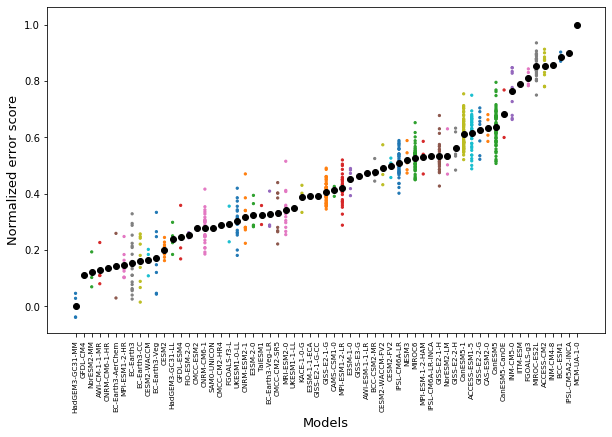

In [16]:
diro = '/glade/work/nlybarger/data/hydromet/ESM_eval_semifinal_plots/final/'
plt.figure(figsize=(10,6))
plt.xticks(ticks=np.arange(nmod),labels=labs,rotation=90,fontsize=7.2)
x = np.arange(nmod)
for i in range(nmod):
#    print(models[i] + ' ' + str(i))
    nensmod = len(pnw_metrics[models[indy[i]]]['ens'])
#    b=np.nansum(relerrs[i,:,:nensmod],axis=0)/relerrtot[i]
#    print(b)
    # print(len(np.full((nensmod),x[i])))
    # print(len(np.nansum(relerrs[i,:,:nensmod],axis=0)))
    plt.scatter(np.full((nensmod),i),(np.nansum(np.squeeze(relerrs[indy[i],:,:nensmod]),axis=0)-relerrtotmin)/max(relerrtot),sizes=np.full((nensmod),5))
plt.scatter(np.arange(nmod),sortie,c='k')
plt.ylabel('Normalized error score',fontsize=13)
plt.xlabel('Models',fontsize=13)
plt.savefig(diro + 'CMIP6_1901-1950.PNW-global.error_norm.png',dpi=450,bbox_inches='tight',facecolor='w')
#plt.close()
#plt.show()

In [16]:
ncihistverif = {}
for mod in models:
    tmpfil = diri + mod + '.historical.nc'
    if os.path.exists(tmpfil):
        ncihistverif[mod] = xr.open_dataset(tmpfil,engine='netcdf4').sel(time=slice('1951-01-01','2014-12-30'),drop=True)
    else:
        continue


In [17]:
# Read in observational datasets for verification period (1951-2014)

odiri = '/glade/work/nlybarger/data/OBS/'
odsets = ['CRU','UDel']
fnames = ['cru','udel']
obsv = {}
ovyears = {}
for i in range(len(odsets)):
    obsv[odsets[i]] = xr.open_dataset(odiri + odsets[i] + '/1deg.' + fnames[i] + '.wconus.p.t.nc',engine='netcdf4')
    obsv[odsets[i]] = obsv[odsets[i]].sel(time=slice('1951-01-01','2014-12-31'))
    ovyears[odsets[i]] = list(obsv[odsets[i]].groupby('time.year').groups)
    
dptrendov = {}
dttrendov = {}

for dset in odsets:
    nyr = len(ovyears[dset])
    tmp = obsv[dset]['pr']/10
    ptmpo = pnw_average(tmp.groupby('time.year').sum(dim='time',skipna=False),'lat','lon')
    ttmpo = pnw_average(obsv[dset]['tas'].groupby('time.year').mean(dim='time',skipna=True),'lat','lon')

    dptrendov[dset] = (xs.linslope(ptmpo['year'], ptmpo, dim='year')*100).data
    dttrendov[dset] = (xs.linslope(ttmpo['year'], ttmpo, dim='year')*100).data
    
ptrendov = np.zeros(1)
ttrendov = np.zeros(1)
for dset in odsets:
    ptrendov = ptrendov + dptrendov[dset]
    ttrendov = ttrendov + dttrendov[dset]

ptrendov = ptrendov/nd
ttrendov = ttrendov/nd

In [ ]:
s_relerrtot=sorted(relerrtot)
nmod=len(models)
culledmodels = ['0']*nmod
for i in range(nmod):
    j = np.where(relerrtot==s_relerrtot[i])[0][0]
    culledmodels[i] = models[j]

In [21]:
ptrends = np.zeros(nmod)
ttrends = np.zeros(nmod)
ptrendhist = np.zeros(nmod)
ttrendhist = np.zeros(nmod)
j=0
for mod in culledmodels:
    ptrendhist[j] = np.nanmean(pnw_metrics[mod]['ptrend'])
    ttrendhist[j] = np.nanmean(pnw_metrics[mod]['ttrend'])
    ptrends[j],ttrends[j],ptmp = compute_trend(ncihistverif[mod])
    j += 1


In [22]:
pthist = np.zeros(nmod)
tthist = np.zeros(nmod)
pthistv = np.zeros(nmod)
tthistv = np.zeros(nmod)
for i in range(1,nmod+1):
#    print(i)
    pthist[i-1] = np.nanmean(ptrendhist[0:i])
    tthist[i-1] = np.nanmean(ttrendhist[0:i])
    pthistv[i-1] = np.nanmean(ptrends[0:i])
    tthistv[i-1] = np.nanmean(ttrends[0:i])

In [23]:
errp = np.abs(pthist-pnw_ptrendo)/np.nanstd(pthist-pnw_ptrendo)
errt = np.abs(tthist-pnw_ttrendo)/np.nanstd(tthist-pnw_ttrendo)
errtot = errp+errt
errtot[0:6] = np.nan
mintot = np.where(errtot == np.nanmin(errtot))

print(mintot)

(array([14]),)


In [ ]:
diro = '/glade/u/home/nlybarger/'

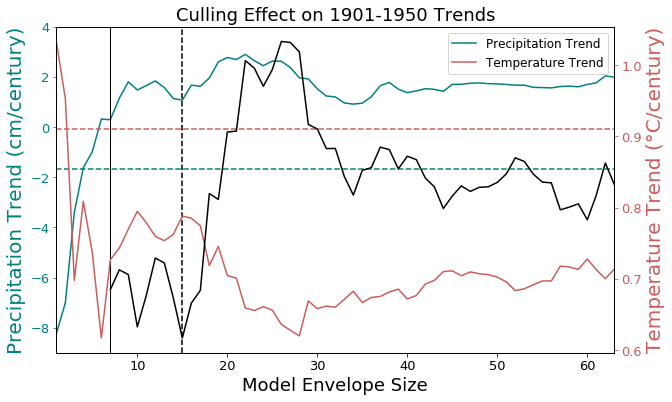

In [24]:
# Plot culling effect on projected P and T trends for evaluation period (1901-1950)
plt.figure(figsize=(10,6))
k=mintot[0].item()+1
pcol = 'teal'
tcol = 'indianred'

ax1 = plt.subplot()
l1, = ax1.plot(np.arange(1,nmod+1),pthist,color=pcol)
ax1.plot([1,nmod],[pnw_ptrendo,pnw_ptrendo],'--',color=pcol)
ax1.set_ylabel('Precipitation Trend (cm/century)',color=pcol,fontsize=20)
ax1.set_ylim(-9,4)
ax1.plot([k,k],[-9,4],'--k')
ax2 = ax1.twinx()
l2, = ax2.plot(np.arange(1,nmod+1),tthist,color=tcol)
ax2.plot([1,nmod],[pnw_ttrendo,pnw_ttrendo],'--',color=tcol)
ax2.set_ylabel('Temperature Trend (°C/century)',color=tcol,fontsize=20)

ax3 = ax1.twinx()
l3, = ax3.plot(np.arange(1,nmod+1),errtot,color='k')
ax3.set_yticks([])
ax1.plot([7,7],[-12,12],'-k',linewidth=1.)

ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.tick_params(axis='y', which='major', colors=pcol)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='y', which='major', colors=tcol)

plt.xlim([1,nmod])
ax1.set_xlabel('Model Envelope Size',fontsize=18)
plt.legend([l1, l2], ["Precipitation Trend", "Temperature Trend"],loc='upper right',fontsize=12)
plt.title('Culling Effect on 1901-1950 Trends', fontsize=18)
plt.savefig(diro + 'CMIP6_1901-1950.PNW.Historical_cullingTrend.png',dpi=450,bbox_inches='tight',facecolor='w')

In [31]:

ttrend_all_mean = np.nanmean(ttrends)
ptrend_all_mean = np.nanmean(ptrends)
ptrend_all_std = np.nanstd(ptrends)
ttrend_all_std = np.nanstd(ttrends)

In [32]:
k=mintot[0].item()
ttrend_cull_mean = np.nanmean(ttrends[:k])
ptrend_cull_mean = np.nanmean(ptrends[:k])
ttrend_cull_std = np.nanstd(ttrends[:k])
ptrend_cull_std = np.nanstd(ptrends[:k])

In [39]:
1/(ttrend_cull_mean/ttrend_all_mean)

0.9139087435227513

In [43]:
2.2/2.0

1.1

In [42]:
ttrend_all_mean

2.001802043598195

In [38]:
1/(ptrend_cull_mean/ptrend_all_mean)

0.6549299441335503

In [35]:
ttrend_cull_std/ttrend_all_std

0.666663556121883

In [40]:
1/(ptrend_cull_std/ptrend_all_std)

0.8741781459964413

In [44]:
ptrend_cull_mean

0.8156740610136818

In [45]:
ptrend_all_mean

0.5342093672108768

4.189110656823082
0.5500719773405128
4.792056031151498
0.36671294053682213


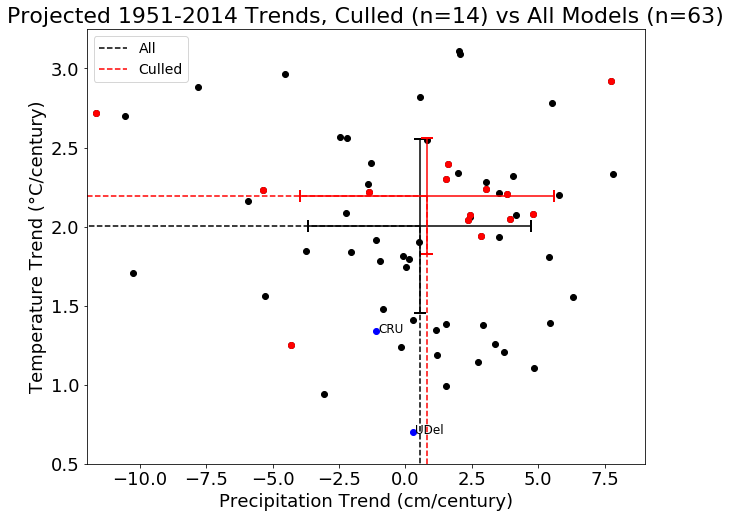

In [33]:
# Plot culling effect on "projected" trend for verification period

plt.figure(figsize=(10,8))
k=mintot[0].item()

t = ttrends
tmean = np.nanmean(t)
p = ptrends
pmean = np.nanmean(p)
perr = np.nanstd(p)
terr = np.nanstd(t)
print(perr)
print(terr)
for j in range(nmod):
    plt.scatter(p[j],t[j],color='k')
plt.plot([-12.5,pmean],[tmean, tmean],'--k',label='All')
plt.plot([pmean,pmean],[-0.5,tmean],'--k')
plt.errorbar(pmean,tmean,xerr=perr,yerr=terr,color='k',capsize=6,capthick=2)

t = ttrends[:k]
tmean = np.nanmean(t)
p = ptrends[:k]
pmean = np.nanmean(p)
perr = np.nanstd(p)
terr = np.nanstd(t)
print(perr)
print(terr)
for j in range(k):
    plt.scatter(p[j],t[j],color='r')
plt.plot([-12.,pmean],[tmean, tmean],'--r',label='Culled')
plt.plot([pmean,pmean],[0.5,tmean],'--r')
plt.errorbar(pmean,tmean,xerr=perr,yerr=terr,color='r',capsize=6,capthick=2)
plt.scatter(dptrendov['CRU'],dttrendov['CRU'],color='b')
plt.scatter(dptrendov['UDel'],dttrendov['UDel'],color='b')
plt.annotate('CRU', (dptrendov['CRU']+0.08,dttrendov['CRU']-0.01),fontsize=12)
plt.annotate('UDel', (dptrendov['UDel']+0.08,dttrendov['UDel']-0.01),fontsize=12)
plt.xlim(-12.,9.)
plt.xlabel('Precipitation Trend (cm/century)',fontsize=18)
plt.ylim(0.5,3.25)
plt.ylabel('Temperature Trend (°C/century)',fontsize=18)
plt.title('Projected 1951-2014 Trends, Culled (n=' + str(k) + ') vs All Models (n=' + str(nmod) +')',fontsize=22)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=18)
#plt.show()
plt.savefig(diro + 'CMIP6_1951-2014.PNW.PTtrends_culled.png',dpi=450,bbox_inches='tight',facecolor='w')
#plt.close()